In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['danbooru-metadata', 'moeimouto-faces', 'danbooru-images']


In [2]:
import tensorflow as tf

#### Below codes are my own practice of colorizing black-white binary image. Please note that I've looked up many codes, so the codes may look similar to other professionals' codes. If this causes problem, please leave comments and I'll delete the kernel. Thank you!

In [3]:
##### This is for implementing U-Net model

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, ZeroPadding2D
from keras.layers import InputLayer, concatenate, BatchNormalization, Dropout, Activation, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

Using TensorFlow backend.


In [4]:
##### model (obtained from https://github.com/zhixuhao/unet)

def model(image_size, kernel_size = 8, optimizer = 'adam'):

    n_classes=2 # This is the number of output channel. Since it's AB channel for us, the number equals to 2
    n_channels=1 # This si the numper of input channel, which is just 1 (L channel)
    n_filters_start=kernel_size # This is the number of filters for convolutional layer to start
    growth_factor=2 # This is the factor number indicating how much deeper convolutional layers are going to be.
    upconv=False # Whether to use Conv2dTranspose or UpSampling2D layer for up-convolution process. 

    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((image_size[0], image_size[1], n_channels))
    input2 = inputs
    # input2 = BatchNormalization()(input2)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(input2)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    # pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    # pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    # pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    # pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    # pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    # pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv: # conv4_1 layer is covolutioned layer from pool4_1 layer
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    # up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    # conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    # up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    # conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    # up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    # conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    # up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    # conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='tanh')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.summary()
    tf.keras.utils.plot_model(model, show_shapes=True)
    model.compile(optimizer=optimizer, loss='mse')

    return model

In [5]:
##### This is for image preprocessing. For more information about RGB to LAB image, you can visit my Github readme (https://github.com/dabsdamoon/Anime-Colorization)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab


In [6]:
##### function transforming from RGB to LAB image

def rgb_lab_transformation(image_resized, image_size):
    
    # create 3 dimensional gray image with rgb2gray * 3
    image_gray = rgb2gray(image_resized).reshape(image_size[0], image_size[1], 1) # this will be the validation dataset
    image_gray3 = np.concatenate([image_gray]*3, axis = 2)
    image_lab3 = rgb2lab(image_gray3)
    image_feature = image_lab3[:,:,0]/128 # scaling from -1 to 1 based on LAB space value range

    # create label first with rgb2lab image
    image_lab = rgb2lab(image_resized)
    image_label = image_lab[:,:,1:]/128 # scaling from -1 to 1 based on LAB space value range
    
    return image_feature, image_label # return feature would be 1st column of lab image generated by gray3 image

##### Function creating individual feature and label

def feature_label_generation(character_dir, filename_list, image_size):
    
    feature = []
    label = []
    
    for filename_num in range(len(filename_list)):
    
        image_chosen = cv2.resize(plt.imread(character_dir + filename_list[filename_num]), image_size)

        if image_chosen.shape[2] == 3:

            feature_indiv, label_indiv = rgb_lab_transformation(image_chosen, image_size)

            feature.append(feature_indiv)
            label.append(label_indiv)

    return feature, label


In [7]:
##### creating dictionaries

dir_name = '../input/moeimouto-faces/moeimouto-faces/'

size_row, size_col = 128, 128

folder_name = os.listdir(dir_name)

character_name = [i[4:] for i in folder_name]
character_name.sort()

folder_dict = {}

for i in range(len(folder_name)):
    folder_dict[folder_name[i][4:]] = folder_name[i]

single_character= 'melon-chan'

file_list = os.listdir(dir_name + folder_dict[single_character])
image_list = [i for i in file_list if i[-3:] == 'png']
# image_dict[folder_name[i][4:]] = image_list

In [8]:
##### pull out 1 image for observing the colorization process
image_pop = image_list.pop(76)

In [9]:
##### Create feature and label

feature = []
label = []
image_size = (size_row, size_col)

for filename in image_list:

    image_chosen = cv2.resize(plt.imread(dir_name + '/' + folder_dict[single_character] + '/' + filename), image_size)

    if image_chosen.shape[2] == 3:

        feature_indiv, label_indiv = rgb_lab_transformation(image_chosen, image_size)

        feature.append(feature_indiv)
        label.append(label_indiv)
        
x_feature = np.array(feature).reshape(len(feature), size_row, size_col, 1)
x_label = np.array(label).reshape(len(label), size_row, size_col, 2)

In [10]:
##### Define model

K.clear_session()

input_shape = (size_row,size_col,1)
kernel_size = 4

model = model(image_size = input_shape[:2], kernel_size = kernel_size, optimizer = Adam(0.0002, 0.5))
tf.keras.utils.plot_model(model, show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 4)  148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 4)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

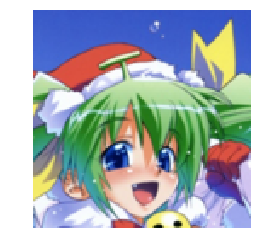

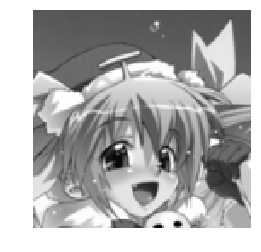

In [11]:
##### Make the image binary (grayscale)

image_valid = cv2.resize(plt.imread(dir_name + '/' + folder_dict[single_character] + '/' + image_pop), image_size)

plt.imshow(image_valid)
plt.axis('off')
plt.show()

img_gray = rgb2gray(image_valid).reshape(128, 128, 1)
img_gray3 = np.concatenate([img_gray]*3, axis = 2) # concatenating three gray images so that it can have 3 channels
img_lab3 = rgb2lab(img_gray3) # convert concatenated image to lab

plt.imshow(img_gray.reshape(128, 128), cmap = 'gray')
plt.axis('off')
plt.show()

In [12]:
##### Fit the model

model_loss = []
img_colorized = []

epochs = 100
save_interval = int(epochs/20) # later, going to visualize training process with 20 images  

for i in range(epochs):

    model_hist = model.fit(x=x_feature, 
                           y=x_label, 
                           batch_size= 32, 
                           epochs=1,
                           verbose = 0)
    
    model_loss.append(model_hist.history['loss'])
    
    if i % save_interval == 0:
        
        print(i, model_hist.history['loss'])
        
        valid_input = img_lab3[:,:,0].reshape(1, size_row, size_col, 1)/128
        
        pred = model.predict(valid_input)    
        pred = pred.reshape(size_row, size_col, 2)
        
        cur_pred = np.zeros((size_row, size_col, 3))             
        # Output colorizations
        cur_pred[:,:,0] = valid_input.reshape(size_row, size_col) * 128 # lab class
        cur_pred[:,:,1:] = pred*128 # lab predicted
        
        img_colorized.append(lab2rgb(cur_pred))        

0 [0.028835658770949804]
5 [0.02415213181615569]
10 [0.02282075064487813]
15 [0.021701049236508535]
20 [0.020008713234389245]
25 [0.018266597972070985]
30 [0.016176041782393243]
35 [0.014442272412106973]
40 [0.012352470023369835]
45 [0.010905485603842855]
50 [0.009786267541060153]
55 [0.008834333413518792]
60 [0.008159713682451452]
65 [0.007395558616926157]
70 [0.007038496813715198]
75 [0.006851534945745917]
80 [0.006333471371525133]
85 [0.006228161457738327]
90 [0.005811825475850424]
95 [0.005520405542004362]


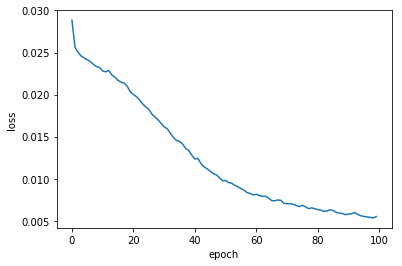

In [13]:
##### Plot loss function

plt.plot(model_loss)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

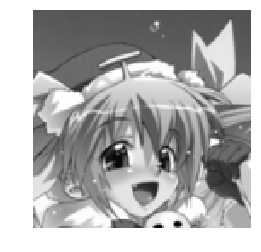

In [14]:
##### Visualization of input value

input_val = img_gray.copy()
plt.imshow(input_val.reshape(size_row, size_col), cmap = 'gray')
plt.axis('off')
plt.show()

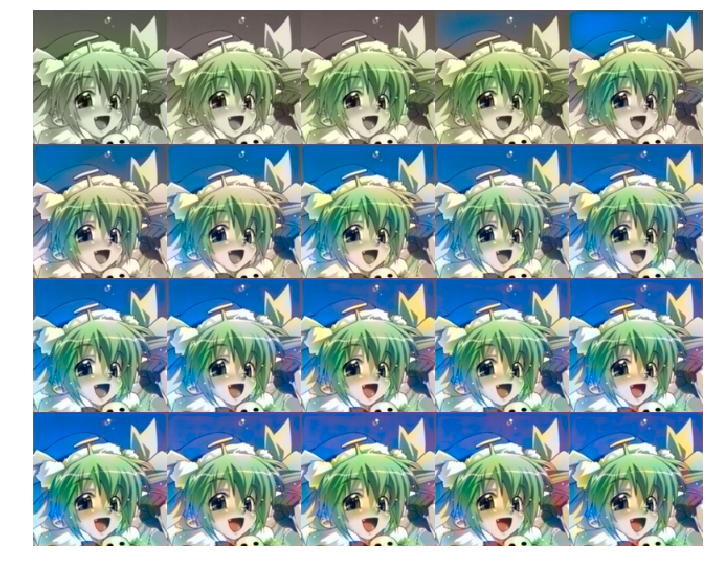

In [15]:
##### Visualizing the learning process

grid_row = 4
grid_col = 5

g_row = []
i = 0

for r in range(grid_row):
    
    g_column = []
    
    for c in range(grid_col):
        g_column.append(img_colorized[i])
        i += 1
        
    g_column = np.concatenate(g_column, axis = 1)
    g_row.append(g_column)

g_row = np.concatenate(g_row)

plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(g_row)

In [25]:
##### Fun exercise: use another character for validation input!

img_another = cv2.resize(plt.imread(dir_name + folder_dict['kinomoto_sakura'] + '/' +  os.listdir(dir_name + folder_dict['kinomoto_sakura'])[5]), image_size)

img_gray = rgb2gray(img_another).reshape(128, 128, 1)
img_gray3 = np.concatenate([img_gray]*3, axis = 2) # concatenating three gray images so that it can have 3 channels
img_lab3 = rgb2lab(img_gray3) # convert concatenated image to lab

valid_input = img_lab3[:,:,0].reshape(1, size_row, size_col, 1)/128

pred = model.predict(valid_input)    
pred = pred.reshape(size_row, size_col, 2)

image_pred = np.zeros((size_row, size_col, 3))             
# Output colorizations
image_pred[:,:,0] = valid_input.reshape(size_row, size_col) * 128 # lab class
image_pred[:,:,1:] = pred*128 # lab predicted


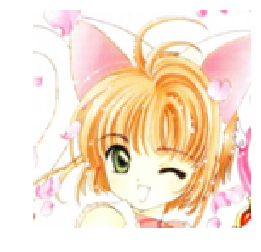

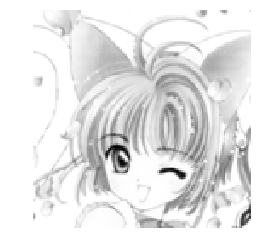

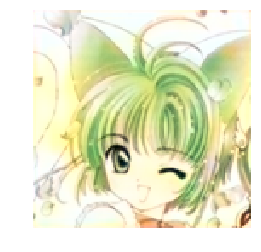

In [26]:
plt.imshow(img_another)
plt.axis('off')
plt.show()

plt.imshow(img_gray.reshape(128, 128), cmap = 'gray')
plt.axis('off')
plt.show()

plt.imshow(lab2rgb(image_pred))
plt.axis('off')
plt.show()

### For more information, visit following links:

<p> General colorization ideas and codes: https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/ </p>
<p> U-Net paper: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ </p>
<p> U-Net Keras implementation:  https://github.com/zhixuhao/unet </p>
<p> More detailed version: https://github.com/dabsdamoon/Anime-Colorization  (This is my own Github) </p>

Thank you for reading and any comments/suggests are welcome.